# Compare ATL06SR to CDEC
## Calculate bias, RMSE, and MAE

In [15]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import scipy.stats
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.time import Time
import datetime
import rioxarray as rxr
from rasterio.plot import show
import rasterio as rio
from rasterio import features
from rasterstats import zonal_stats
import hvplot.pandas
import pickle
from scipy import stats
from scipy.signal import savgol_filter
#from holoviews.element.tiles import EsriImagery, StamenTerrain
from geoviews import opts, tile_sources as gvts
from matplotlib.lines import Line2D
#from datetime import datetime
#from imview.lib import pltlib

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.facecolor']='w'
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

plt.rcParams['font.size'] = '16'

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
def nmad(df):
    return scipy.stats.median_abs_deviation(df, nan_policy='omit', scale='normal')

def p16(df):
    return np.nanpercentile(df, 16)

def p84(df):
    return np.nanpercentile(df, 84)

def spread(df):
    return p84(df) - p16(df)

In [6]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

In [7]:
#map_tiles = EsriImagery()
#map_tiles = StamenTerrain()
map_tiles = gvts.StamenTerrain

In [8]:
kw = {'width':500, 'height':400, 'hover':False, 'data_aspect':1, 'alpha':1.0}
kw['colorbar'] = True
kw['cmap'] = 'inferno'
#kw['s'] = 1
#kw['aggregator'] = 'mean'
#kw['rasterize'] = False
#Using datashade drops colorbar
kw['datashade'] = True
#kw['dynamic'] = True
#kw['backend'] = 'matplotlib'

In [9]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [10]:
mpl_epoch = '1970-01-01'

In [11]:
def iqr(x):
    IQR = stats.iqr(x, interpolation = 'midpoint', nan_policy='omit')
    return IQR

In [33]:
atl06sr_gdf = pickle.load(open('../../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed_bicubic_snowonaso.pkl', 'rb'))
atl06sr_gdf_cdec = pickle.load(open('../../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed.pkl', 'rb'))

outline_gdf = pickle.load(open('../../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))
outline_nolakes = pickle.load(open('../../../data/site_outlines/tuol_outline_nolakes.pkl', 'rb'))

snwd = pickle.load(open('../../data/CDEC/cdec_gdf.pkl', 'rb'))

aso_gdf = pickle.load(open('../../../data/misc/aso_dates.pkl', 'rb'))

cdec_geom = pickle.load(open('../../data/CDEC/cdec_geometries.pkl', 'rb'))

## Create this table for all ATL06SR Data

In [24]:
atl06sr_gdf['zscore'] = (atl06sr_gdf['diff_plus'] - atl06sr_gdf['diff_plus'].mean()) / atl06sr_gdf['diff_plus'].std()

zscore_thresh = 3
absdiff_thresh = 5.0

In [25]:
atl06_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & (atl06sr_gdf['diff_plus'].abs() <= absdiff_thresh)

inner_snowoff_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 0)

inner_snowon_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 1)

In [272]:
def make_comparison_table(df):
    comp_table_all = pd.DataFrame()
    comp_table_all.index = pd.DatetimeIndex(data=df['acqdate'].unique())
    comp_table_all['acqdate'] = comp_table_all.index.date
    
    # compute the median depth for each ATL06 date
    comp_table_all['median'] = ''
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'median'] = np.nanmedian(df.loc[df['acqdate']==date,'diff_plus_bicubic'])
    
    # compute the iqr for each ATL06 date
    comp_table_all['iqr'] = ''
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'iqr'] = iqr(df.loc[df['acqdate']==date,'diff_plus_bicubic'])
    
    # compute the sample size for each ATL06 date
    comp_table_all['n'] = ''
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'n'] = df.loc[df['acqdate']==date, 'diff_plus_bicubic'].count()
    
    # compute the depth on that day at the tuolumne meadows cdec pillow
    comp_table_all['tum_depth'] = ''
    for date in comp_table_all.index.to_pydatetime():
        comp_table_all.loc[comp_table_all.index==date,'tum_depth'] = snwd[snwd.index == date]['tum_m']
    
    # compute the depth on that day at the dana meadows cdec pillow
    comp_table_all['dan_depth'] = ''
    for date in comp_table_all.index.to_pydatetime():
        comp_table_all.loc[comp_table_all.index==date,'dan_depth'] = snwd[snwd.index == date]['dan_clean']
    
    # compute the difference between the atl06 median depth and the depth on that day at the dana meadows snow pillow
    comp_table_all['atl06-dan_diff'] = ''
    for date in comp_table_all.index.to_pydatetime():
        comp_table_all.loc[comp_table_all.index==date,'atl06-dan_diff'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'dan_depth']
    
    # compute the percent difference between the atl06 median depth and dana meadows.
    comp_table_all['atl06-dan_percent'] = ''
    for date in comp_table_all.index.to_pydatetime():
        comp_table_all.loc[comp_table_all.index==date,'atl06-dan_percent'] = (comp_table_all.loc[comp_table_all.index==date,'atl06-dan_diff'] / comp_table_all.loc[comp_table_all.index==date,'dan_depth']) * 100
    
    # compute the difference between the atl06 median depth and the depth on that day at the tuolumne meadows snow pillow    
    comp_table_all['atl06-tum_diff'] = ''
    for date in comp_table_all.index.to_pydatetime():
        comp_table_all.loc[comp_table_all.index==date,'atl06-tum_diff'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'tum_depth']
    
    # compute the percent difference between the atl06 median depth and tuolumne meadows.
    comp_table_all['atl06-tum_percent'] = ''
    for date in comp_table_all.index.to_pydatetime():
        comp_table_all.loc[comp_table_all.index==date,'atl06-tum_percent'] = (comp_table_all.loc[comp_table_all.index==date,'atl06-tum_diff'] / comp_table_all.loc[comp_table_all.index==date,'tum_depth']) * 100
    
    # compute the mean of the tum and dan snow sensors on days with atl06 data
    comp_table_all['cdec_mean'] = ''
    for date in comp_table_all.index.to_pydatetime():
        comp_table_all.loc[comp_table_all.index==date,'cdec_mean'] = (comp_table_all.loc[comp_table_all.index==date,'tum_depth'] + comp_table_all.loc[comp_table_all.index==date,'dan_depth']) / 2
    
    # compute the percent difference between the atl06sr median depth and the average of the two cdec sites
    comp_table_all['atl06-cdec_mean'] = ''
    for date in comp_table_all.index.to_pydatetime():
        comp_table_all.loc[comp_table_all.index==date,'atl06-cdec_mean'] = ((comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'cdec_mean']) / comp_table_all.loc[comp_table_all.index==date,'cdec_mean']) * 100
        
    comp_table_all['rmse_inner_tum'] = np.nan
    for date in comp_table_all.index:
        squared_dif = (df[atl06_idx].loc[df.acqdate==date.date(), 'diff_plus_bicubic'] - comp_table_all.loc[comp_table_all.index==date,'tum_depth'][0])**2
        comp_table_all.loc[comp_table_all.acqdate==date.date(), 'rmse_inner_tum'] = np.sqrt(np.nansum(squared_dif/squared_dif.count()))
        
    comp_table_all['rmse_inner_dan'] = np.nan
    for date in comp_table_all.index:
        squared_dif = (df[atl06_idx].loc[df.acqdate==date.date(), 'diff_plus_bicubic'] - comp_table_all.loc[comp_table_all.index==date,'dan_depth'][0])**2
        comp_table_all.loc[comp_table_all.acqdate==date.date(), 'rmse_inner_dan'] = np.sqrt(np.nansum(squared_dif/squared_dif.count()))
    
    comp_table_all['mae_inner_tum'] = np.nan
    for date in comp_table_all.index:
        abs_dif = abs(atl06sr_gdf[atl06_idx].loc[atl06sr_gdf.acqdate==date.date(), 'diff_plus_bicubic'] - 
                                    comp_table_all.loc[comp_table_all.index==date,'tum_depth'][0])
        abs_dif_sum = np.nansum(abs_dif)
        n = abs_dif.count()
        if n != 0:
            comp_table_all.loc[comp_table_all['acqdate']==date.date(), 'mae_inner_tum'] = abs_dif_sum/n
        else:
            comp_table_all.loc[comp_df['acqdate']==date.date(), 'mae_inner_tum'] = np.nan
    
    comp_table_all['mae_inner_dan'] = np.nan
    for date in comp_table_all.index:
        abs_dif = abs(atl06sr_gdf[atl06_idx].loc[atl06sr_gdf.acqdate==date.date(), 'diff_plus_bicubic'] - 
                                    comp_table_all.loc[comp_table_all.index==date,'dan_depth'][0])
        abs_dif_sum = np.nansum(abs_dif)
        n = abs_dif.count()
        if n != 0:
            comp_table_all.loc[comp_table_all['acqdate']==date.date(), 'mae_inner_dan'] = abs_dif_sum/n
        else:
            comp_table_all.loc[comp_table_all['acqdate']==date.date(), 'mae_inner_dan'] = np.nan
    
    comp_table_all['snow_presence'] = np.nan
    for date in comp_table_all.index.to_pydatetime():
        comp_table_all.loc[comp_table_all.index==date,'snow_presence'] = np.nanmean(df.loc[df['acqdate']==pd.Timestamp(date), 'snow_presence'])
    
    return comp_table_all

In [273]:
comp_df = make_comparison_table(atl06sr_gdf)

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [274]:
comp_df.head()

,acqdate,median,iqr,n,tum_depth,dan_depth,atl06-dan_diff,atl06-dan_percent,atl06-tum_diff,atl06-tum_percent,cdec_mean,atl06-cdec_mean,rmse_inner_tum,rmse_inner_dan,mae_inner_tum,mae_inner_dan,snow_presence
2018-10-15,2018-10-15,-0.173633,0.998251,897,0.0,-0.0254,-0.148233,583.593144,-0.173633,-inf,-0.0127,1267.186287,1.113445,1.109337,0.777633,0.772650,0.0
2018-11-13,2018-11-13,-0.240414,0.285566,17,0.0,-0.0254,-0.215014,846.510516,-0.240414,-inf,-0.0127,1793.021032,0.490883,0.474518,0.353352,0.330940,0.0
2018-12-11,2018-12-11,0.464071,1.588399,6111,0.6604,0.7112,-0.247129,-34.748241,-0.196329,-29.728875,0.6858,-32.331509,1.488947,1.498697,1.092509,1.100862,1.0
2019-01-09,2019-01-09,1.321122,1.176036,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,1.0
2019-02-12,2019-02-12,2.912386,2.057524,3,NaN,2.413,0.499386,20.695633,NaN,NaN,NaN,NaN,0.000000,0.428787,NaN,0.421689,1.0


In [265]:
comp_df

,acqdate,median,iqr,n,tum_depth,dan_depth,atl06-dan_diff,atl06-dan_percent,atl06-tum_diff,atl06-tum_percent,cdec_mean,atl06-cdec_mean,rmse_inner_tum,rmse_inner_dan,mae_inner_tum,mae_inner_dan,snow_presence
2018-10-15,2018-10-15,-0.150095,1.059566,899,0.0,-0.0254,-0.124695,490.926444,-0.150095,-inf,-0.0127,1081.852888,1.113445,1.109337,0.777633,0.772650,0.0
2018-11-13,2018-11-13,-0.276287,0.362926,17,0.0,-0.0254,-0.250887,987.744826,-0.276287,-inf,-0.0127,2075.489653,0.490883,0.474518,0.353352,0.330940,0.0
2018-12-11,2018-12-11,0.477991,1.654234,6115,0.6604,0.7112,-0.233209,-32.790938,-0.182409,-27.62101,0.6858,-30.301713,1.488947,1.498697,1.092509,1.100862,1.0
2019-01-09,2019-01-09,1.24351,1.117565,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,1.0
2019-02-12,2019-02-12,2.950302,1.838642,3,NaN,2.413,0.537302,22.266958,NaN,NaN,NaN,NaN,0.000000,0.428787,NaN,0.421689,1.0
2019-03-12,2019-03-12,2.825406,2.909036,5937,2.4892,2.7178,0.107606,3.959298,0.336206,13.50658,2.6035,8.523365,1.943464,1.997140,1.498989,1.511600,1.0
2019-04-10,2019-04-10,2.452357,1.248204,2393,2.032,NaN,NaN,NaN,0.420357,20.686862,NaN,NaN,1.112252,0.000000,0.855813,NaN,1.0
2019-05-14,2019-05-14,1.596169,1.778233,4090,0.4064,1.143,0.453169,39.647313,1.189769,292.758068,0.7747,106.037019,1.830572,1.479680,1.477616,1.128284,1.0
2019-06-11,2019-06-11,1.222026,1.717712,502,0.0508,0.4572,0.764826,167.284754,1.171226,2305.562789,0.254,381.112558,1.624560,1.378177,1.350660,1.112990,0.0
2019-07-09,2019-07-09,0.08624,0.644352,388,0.0,NaN,NaN,NaN,0.08624,inf,NaN,NaN,0.654320,0.000000,0.439394,NaN,0.0


In [161]:
snwd.head()

,tum_m,dan_m,doy,decyear,dowy,dan_clean
Date,,,,,,
2018-10-01,0.0254,-0.0508,274.0,2018.747945,1.0,-0.0508
2018-10-02,0.0000,NaN,275.0,2018.750685,2.0,NaN
2018-10-03,0.0254,NaN,276.0,2018.753425,3.0,NaN
2018-10-04,0.0254,NaN,277.0,2018.756164,4.0,NaN
2018-10-05,NaN,NaN,NaN,NaN,NaN,NaN


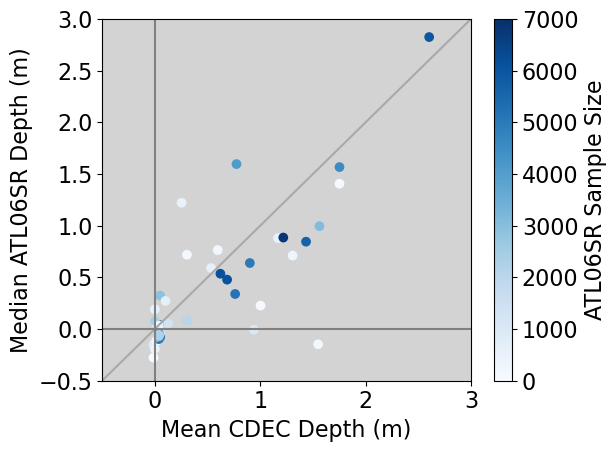

In [165]:
x = np.linspace(-0.7,3,100)
y = x

fig, ax = plt.subplots()
c=plt.scatter(comp_df['cdec_mean'], comp_df['median'], c=comp_df['n'], cmap='Blues', vmin=0, vmax=7000)
plt.plot(x, y, 'darkgrey', label='1:1 line')
plt.axvline(x=0, ymin=(-0.7), ymax=3, color='grey')
plt.axhline(y=0, xmin=(-0.7), xmax=3, color='grey')
plt.colorbar(c, label='ATL06SR Sample Size')
plt.ylim(-0.5, 3)
plt.xlim(-0.5, 3)
plt.xlabel('Mean CDEC Depth (m)')
plt.ylabel('Median ATL06SR Depth (m)')
ax.set_facecolor('lightgrey')
plt.tight_layout()
#plt.savefig('../../figures/polished/median_dif_vs_delta_dan.jpeg', dpi=50

In [450]:
cdec_geom

,geometry,elevation_m,site
0,POINT (293306.562 4194327.335),2621.28,tum
1,POINT (301551.877 4196788.619),2965.00,dan
2,"POLYGON ((298306.562 4194327.335, 298282.486 4...",NaN,tum_5km
3,"POLYGON ((306551.877 4196788.619, 306527.800 4...",NaN,dan_5km


In [275]:
comp_tumradius = make_comparison_table(atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[2, 'geometry'])])

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/geopandas/geodataframe.py:1428: UserWarning:

In [276]:
comp_danradius = make_comparison_table(atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[3, 'geometry'])])

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/geopandas/geodataframe.py:1428: UserWarning:

In [277]:
comp_tumradius.head()

,acqdate,median,iqr,n,tum_depth,dan_depth,atl06-dan_diff,atl06-dan_percent,atl06-tum_diff,atl06-tum_percent,cdec_mean,atl06-cdec_mean,rmse_inner_tum,rmse_inner_dan,mae_inner_tum,mae_inner_dan,snow_presence
2018-11-13,2018-11-13,-0.294677,0.489865,3,0.0,-0.0254,-0.269277,1060.146868,-0.294677,-inf,-0.0127,2220.293736,0.737877,0.717903,0.353352,0.330940,0.0
2019-04-10,2019-04-10,2.291947,1.279624,1282,2.032,NaN,NaN,NaN,0.259947,12.79268,NaN,NaN,1.071191,0.000000,0.855813,NaN,1.0
2019-05-14,2019-05-14,1.046734,1.05693,925,0.4064,1.143,-0.096266,-8.422229,0.640334,157.562482,0.7747,35.114744,1.241877,0.997573,1.477616,1.128284,1.0
2019-07-09,2019-07-09,0.089422,0.657507,124,0.0,NaN,NaN,NaN,0.089422,inf,NaN,NaN,0.569984,0.000000,0.439394,NaN,0.0
2019-12-11,2019-12-11,0.370705,0.732479,131,0.7112,NaN,NaN,NaN,-0.340495,-47.876067,NaN,NaN,0.855862,0.000000,0.993825,NaN,1.0


In [278]:
comp_danradius.head()

,acqdate,median,iqr,n,tum_depth,dan_depth,atl06-dan_diff,atl06-dan_percent,atl06-tum_diff,atl06-tum_percent,cdec_mean,atl06-cdec_mean,rmse_inner_tum,rmse_inner_dan,mae_inner_tum,mae_inner_dan,snow_presence
2019-07-09,2019-07-09,-0.115339,0.348135,67,0.0,NaN,NaN,NaN,-0.115339,-inf,NaN,NaN,0.418004,0.000000,0.439394,NaN,0.0
2019-12-11,2019-12-11,0.53454,1.238889,1307,0.7112,NaN,NaN,NaN,-0.17666,-24.839687,NaN,NaN,1.186553,0.000000,0.993825,NaN,1.0
2020-02-11,2020-02-11,0.717117,0.730012,487,0.7366,NaN,NaN,NaN,-0.019483,-2.644963,NaN,NaN,0.697440,0.000000,0.509151,NaN,1.0
2020-10-06,2020-10-06,-0.118187,0.417504,26,0.0,0.0,-0.118187,-inf,-0.118187,-inf,0.0,-inf,0.367357,0.367357,0.451856,0.451856,0.0
2020-12-08,2020-12-08,0.738853,2.095692,180,0.254,0.3556,0.383253,107.776378,0.484853,190.88693,0.3048,142.405775,1.724085,1.695279,1.367139,1.348859,1.0


In [258]:
comp_tumradius = comp_tumradius.drop(columns=['dan_depth', 'atl06-dan_diff', 'atl06-dan_percent'])

In [259]:
comp_danradius = comp_danradius.drop(columns=['tum_depth', 'atl06-tum_diff', 'atl06-tum_percent'])

In [171]:
comp_tumradius.to_csv('../../figures/comp_tumradius.csv')
comp_danradius.to_csv('../../figures/comp_danradius.csv')

In [247]:
comp_danradius.head(2)

,acqdate,median,iqr,n,dan_depth,atl06-dan_diff,atl06-dan_percent,cdec_mean,atl06-cdec_mean
2019-07-09,2019-07-09,-0.032246,0.373705,67,NaN,NaN,NaN,NaN,NaN
2019-12-11,2019-12-11,0.543399,1.261553,1307,NaN,NaN,NaN,NaN,NaN


In [288]:
np.nanmedian(comp_tumradius[comp_tumradius['snow_presence']==1]['atl06-tum_percent'].abs())

22.81320125627248

In [289]:
np.nanmedian(comp_tumradius['atl06-tum_percent'].abs())

74.63142371244692

In [287]:
for data in [(comp_df[comp_df['snow_presence']==1]['iqr']), comp_df[comp_df['snow_presence']==1]['atl06-tum_diff'], \
             comp_df[comp_df['snow_presence']==1]['atl06-tum_percent'], comp_df[comp_df['snow_presence']==1]['atl06-dan_diff'], \
            comp_df[comp_df['snow_presence']==1]['atl06-dan_percent'], comp_tumradius[comp_tumradius['snow_presence']==1]['iqr'], \
            comp_tumradius[comp_tumradius['snow_presence']==1]['atl06-tum_diff'], comp_tumradius[comp_tumradius['snow_presence']==1]['atl06-tum_percent'], \
            comp_danradius[comp_danradius['snow_presence']==1]['atl06-dan_diff'], comp_danradius[comp_danradius['snow_presence']==1]['atl06-dan_percent'], \
            comp_danradius[comp_danradius['snow_presence']==1]['iqr']]:
    print(f'{data.name}', 'median =', np.nanmedian(data.abs()))

iqr median = 1.2492877224473204
atl06-tum_diff median = 0.21461617015184203
atl06-tum_percent median = 28.5410215215685
atl06-dan_diff median = 0.45702322967205566
atl06-dan_percent median = 41.48752070510733
iqr median = 0.7031003418849195
atl06-tum_diff median = 0.1799892255039115
atl06-tum_percent median = 22.81320125627248
atl06-dan_diff median = 0.543928369211129
atl06-dan_percent median = 44.87084964894188
iqr median = 0.7449141811357549


In [242]:
np.nanmedian(comp_df['iqr'])

1.1940300780224788

In [243]:
np.nanmedian(comp_tumradius['iqr'])

0.7006659543594651

In [550]:
np.nanmax(comp_tumradius['atl06-tum_diff'].abs())

0.6595482265384668

In [237]:
np.nanmedian(comp_tumradius['atl06-tum_diff'].abs())

0.16764758616764153

In [239]:
np.nanmedian(comp_df['atl06-tum_diff'].abs())

0.18077983325046407

In [238]:
np.nanmedian(comp_tumradius['atl06-tum_percent'].abs())

74.63142371244692

In [240]:
np.nanmedian(comp_df['atl06-tum_percent'].abs())

150.68128907229894

In [553]:
np.nanmin(comp_tumradius['atl06-tum_percent'].abs())

1.9149990814673057

In [554]:
np.nanmax(comp_tumradius['atl06-tum_percent'].abs())

inf

In [244]:
np.nanmedian(comp_danradius['atl06-dan_diff'].abs())

0.36336423665180007

In [248]:
np.nanmedian(comp_danradius['atl06-dan_percent'].abs())

102.18341863098989

In [249]:
np.nanmedian(comp_danradius['iqr'].abs())

0.7923656585458048

In [252]:
np.nanmedian(comp_df['atl06-dan_percent'].abs())

107.25183614093345

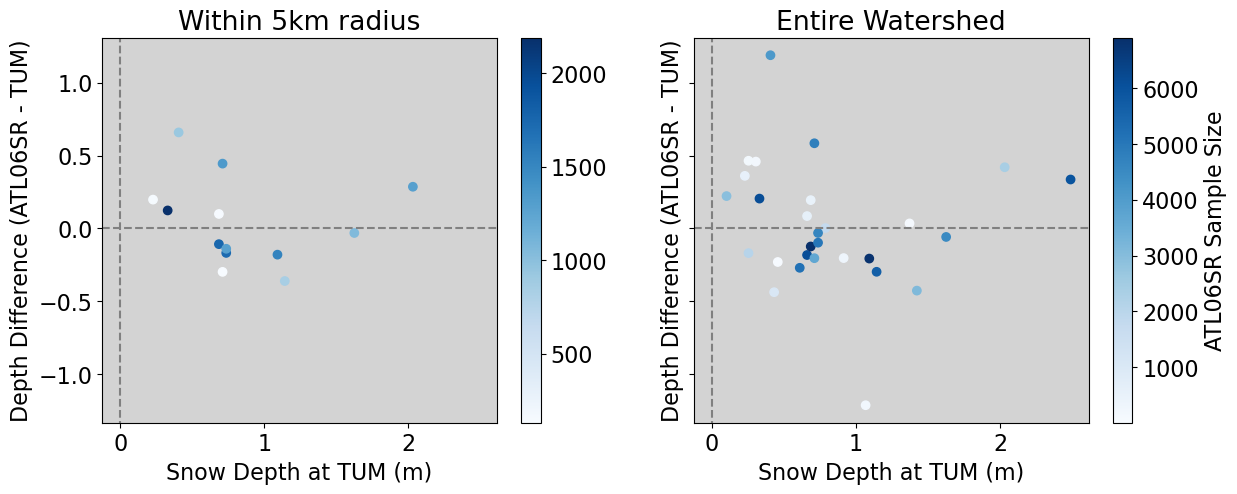

In [260]:
fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True, sharex=True)
#c = plt.scatter(comp_tumradius['tum_depth'], comp_tumradius['atl06-tum_diff'], c=comp_tumradius['n'], cmap='Blues')
c1 = ax[0].scatter(comp_tumradius[comp_tumradius['snow_presence']==1]['tum_depth'], comp_tumradius[comp_tumradius['snow_presence']==1]['atl06-tum_diff'], c=comp_tumradius[comp_tumradius['snow_presence']==1]['n'], cmap='Blues') # , linewidth=0, marker='.'
ax[0].set_xlabel('Snow Depth at TUM (m)')
ax[0].set_ylabel('Depth Difference (ATL06SR - TUM)')
ax[0].axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
ax[0].axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')
ax[0].set_title('Within 5km radius')
ax[0].set_facecolor('lightgrey')
fig.colorbar(c1, ax=ax[0])

c = ax[1].scatter(comp_df[comp_df['snow_presence']==1]['tum_depth'], comp_df[comp_df['snow_presence']==1]['atl06-tum_diff'], c=comp_df[comp_df['snow_presence']==1]['n'], cmap='Blues')
ax[1].set_xlabel('Snow Depth at TUM (m)')
ax[1].set_ylabel('Depth Difference (ATL06SR - TUM)')
ax[1].axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
ax[1].axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')
ax[1].set_title('Entire Watershed')
ax[1].set_facecolor('lightgrey')
fig.colorbar(c, ax=ax[1], label='ATL06SR Sample Size')

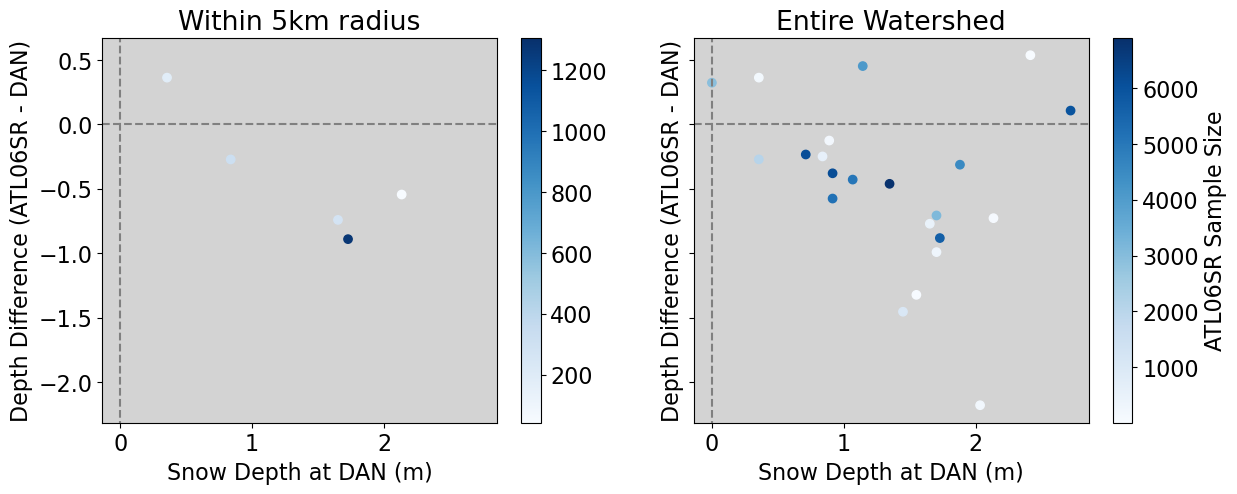

In [261]:
fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True, sharex=True)
#c = plt.scatter(comp_tumradius['tum_depth'], comp_tumradius['atl06-tum_diff'], c=comp_tumradius['n'], cmap='Blues')
c1 = ax[0].scatter(comp_danradius[comp_danradius['snow_presence']==1]['dan_depth'], comp_danradius[comp_danradius['snow_presence']==1]['atl06-dan_diff'], c=comp_danradius[comp_danradius['snow_presence']==1]['n'], cmap='Blues') # , linewidth=0, marker='.'
ax[0].set_xlabel('Snow Depth at DAN (m)')
ax[0].set_ylabel('Depth Difference (ATL06SR - DAN)')
ax[0].axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
ax[0].axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')
ax[0].set_title('Within 5km radius')
ax[0].set_facecolor('lightgrey')
fig.colorbar(c1, ax=ax[0])

c = ax[1].scatter(comp_df[comp_df['snow_presence']==1]['dan_depth'], comp_df[comp_df['snow_presence']==1]['atl06-dan_diff'], c=comp_df[comp_df['snow_presence']==1]['n'], cmap='Blues')
ax[1].set_xlabel('Snow Depth at DAN (m)')
ax[1].set_ylabel('Depth Difference (ATL06SR - DAN)')
ax[1].axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
ax[1].axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')
ax[1].set_title('Entire Watershed')
ax[1].set_facecolor('lightgrey')
fig.colorbar(c, ax=ax[1], label='ATL06SR Sample Size')

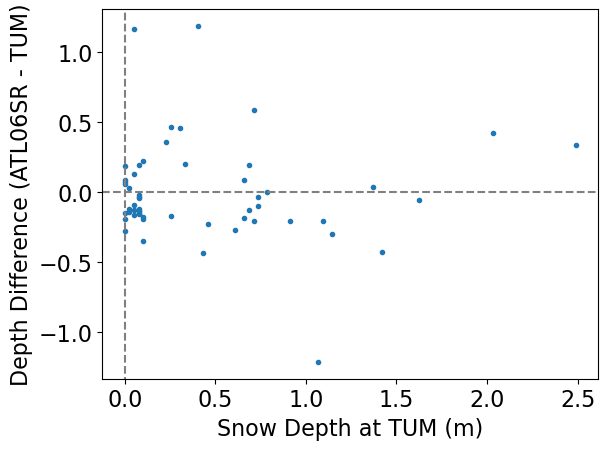

In [193]:
fig, ax = plt.subplots()
plt.plot(comp_df['tum_depth'], comp_df['atl06-tum_diff'], linewidth=0, marker='.')
plt.xlabel('Snow Depth at TUM (m)')
plt.ylabel('Depth Difference (ATL06SR - TUM)')
plt.axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
plt.axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')

<AxesSubplot: >

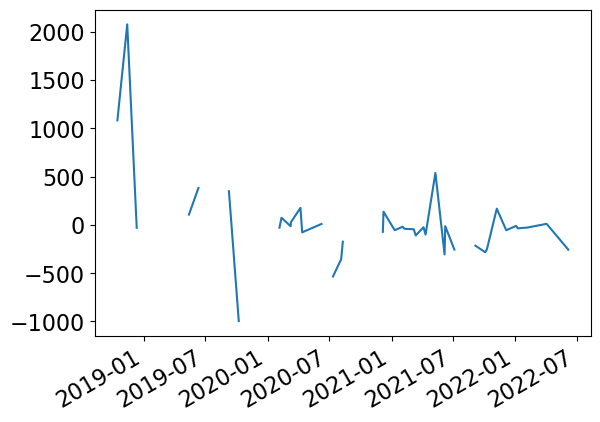

In [464]:
comp_df['atl06-cdec_mean'].plot()

<AxesSubplot: >

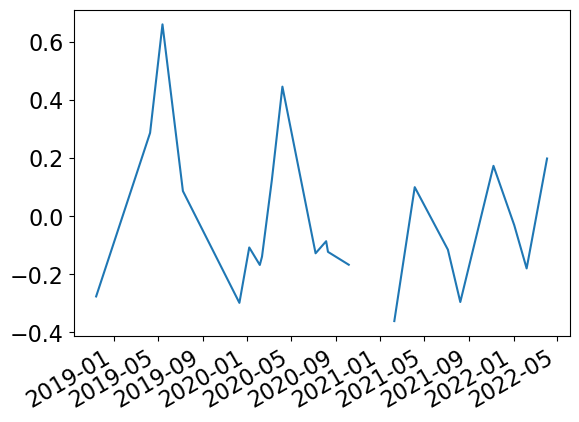

In [470]:
comp_tumradius['atl06-tum_diff'].plot()

<AxesSubplot: >

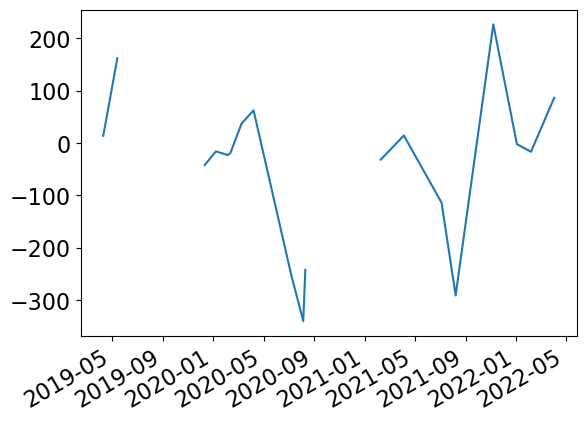

In [471]:
comp_tumradius['atl06-tum_percent'].plot()

<AxesSubplot: >

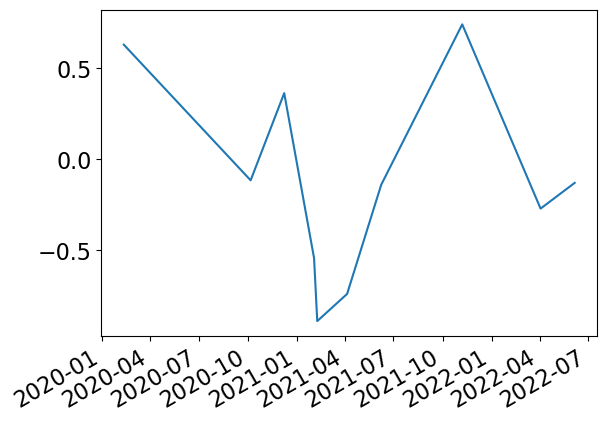

In [460]:
comp_df_danradius['atl06-dan_diff'].plot()

In [465]:
comp_df_tumradius.head()

,acqdate,median,iqr,n,tum_depth,dan_depth,atl06-dan_diff,atl06-tum_diff,cdec_mean,atl06-cdec_mean
2018-11-13,2018-11-13,-0.276287,0.459613,3,0.0,-0.0254,-0.250887,-0.276287,-0.0127,2075.489653
2019-04-10,2019-04-10,2.318431,1.338913,1284,2.032,NaN,NaN,0.286431,NaN,NaN
2019-05-14,2019-05-14,1.065948,1.075131,925,0.4064,1.143,-0.077052,0.659548,0.7747,37.594969
2019-07-09,2019-07-09,0.08624,0.743908,124,0.0,NaN,NaN,0.08624,NaN,NaN
2019-12-11,2019-12-11,0.412816,0.654866,131,0.7112,NaN,NaN,-0.298384,NaN,NaN


In [447]:
comp_df

,acqdate,median,iqr,n,tum_depth,dan_depth,atl06-dan_diff,atl06-tum_diff,cdec_mean,atl06-cdec_mean
2018-10-15,2018-10-15,-0.150095,1.059566,899,0.0,-0.0254,-0.124695,-0.150095,-0.0127,1081.852888
2018-11-13,2018-11-13,-0.276287,0.362926,17,0.0,-0.0254,-0.250887,-0.276287,-0.0127,2075.489653
2018-12-11,2018-12-11,0.477991,1.654234,6115,0.6604,0.7112,-0.233209,-0.182409,0.6858,-30.301713
2019-01-09,2019-01-09,1.24351,1.117565,61,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-12,2019-02-12,2.950302,1.838642,3,NaN,2.413,0.537302,NaN,NaN,NaN
2019-03-12,2019-03-12,2.825406,2.909036,5937,2.4892,2.7178,0.107606,0.336206,2.6035,8.523365
2019-04-10,2019-04-10,2.452357,1.248204,2393,2.032,NaN,NaN,0.420357,NaN,NaN
2019-05-14,2019-05-14,1.596169,1.778233,4090,0.4064,1.143,0.453169,1.189769,0.7747,106.037019
2019-06-11,2019-06-11,1.222026,1.717712,502,0.0508,0.4572,0.764826,1.171226,0.254,381.112558
2019-07-09,2019-07-09,0.08624,0.644352,388,0.0,NaN,NaN,0.08624,NaN,NaN


In [316]:
comp_table_all = pd.DataFrame()
comp_table_all.index = pd.DatetimeIndex(data=atl06sr_gdf['acqdate'].unique())
comp_table_all['acqdate'] = comp_table_all.index.date

In [318]:
comp_table_all['median'] = ''
for date in comp_table_all['acqdate']:
    comp_table_all.loc[comp_table_all['acqdate']==date, 'median'] = np.nanmedian(atl06sr_gdf.loc[atl06sr_gdf['acqdate']==date,'diff_plus'])

In [319]:
comp_table_all['iqr'] = ''
for date in comp_table_all['acqdate']:
    comp_table_all.loc[comp_table_all['acqdate']==date, 'iqr'] = iqr(atl06sr_gdf.loc[atl06sr_gdf['acqdate']==date,'diff_plus'])

In [320]:
comp_table_all['n'] = ''
for date in comp_table_all['acqdate']:
    comp_table_all.loc[comp_table_all['acqdate']==date, 'n'] = atl06sr_gdf.loc[atl06sr_gdf['acqdate']==date, 'diff_plus'].count()

In [321]:
comp_table_all['tum_depth'] = ''
# median depth on that day at the tuolumne meadows cdec pillow
for date in comp_table_all.index:
    comp_table_all.loc[comp_table_all.index==date,'tum_depth'] = snwd[snwd.index == date]['tum_m']

In [322]:
comp_table_all['dan_depth'] = ''
# median depth on that day at the tuolumne meadows cdec pillow
for date in comp_table_all.index:
    comp_table_all.loc[comp_table_all.index==date,'dan_depth'] = snwd[snwd.index == date]['dan_m']

In [323]:
comp_table_all['atl06-dan_diff'] = ''
for date in comp_table_all.index:
    comp_table_all.loc[comp_table_all.index==date,'atl06-dan_diff'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'dan_depth']

In [324]:
comp_table_all['atl06-tum_diff'] = ''
for date in comp_table_all.index:
    comp_table_all.loc[comp_table_all.index==date,'atl06-tum_diff'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'tum_depth']

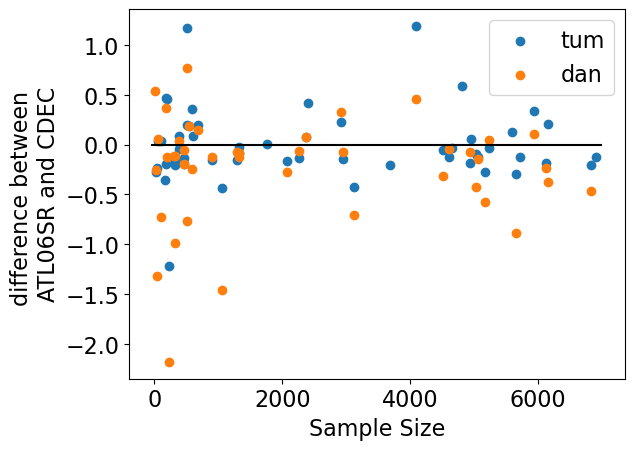

In [144]:
fig, ax = plt.subplots()
plt.scatter(comp_df['n'], comp_df['atl06-tum_diff'], label='tum')
plt.scatter(comp_df['n'], comp_df['atl06-dan_diff'], label='dan')
plt.hlines(y=0, xmin=-50, xmax=7000, color='k')
plt.xlabel('Sample Size')
plt.ylabel('difference between \nATL06SR and CDEC')
plt.legend()

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/histograms.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/histograms.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


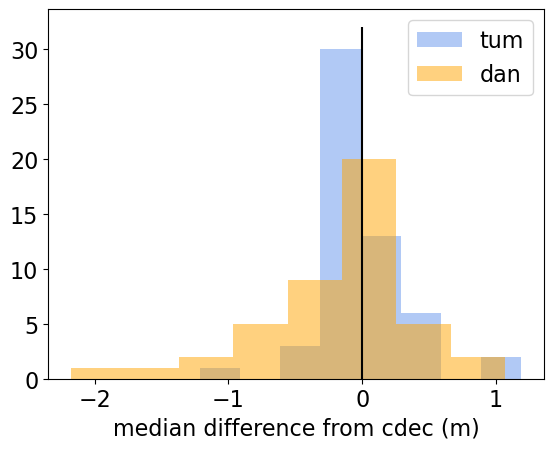

In [326]:
fig, ax = plt.subplots()
plt.hist(comp_table_all['atl06-tum_diff'], bins=round(np.sqrt(len(comp_table_all))), label='tum', alpha=0.5, color='cornflowerblue')
plt.hist(comp_table_all['atl06-dan_diff'], bins=round(np.sqrt(len(comp_table_all))), label='dan', alpha=0.5, color='orange')
plt.vlines(x=0, ymin=0, ymax=32, color='k')
plt.xlabel('median difference from cdec (m)')
#plt.ylabel('difference between \nATL06SR and CDEC')
plt.legend()

In [181]:
print('Median of the median differences between ATL06SR and DAN:', np.nanmedian(comp_table_all['atl06-dan_diff']))
print('Median of the median differences between ATL06SR and TUM:', np.nanmedian(comp_table_all['atl06-tum_diff']))

Median of the median differences between ATL06SR and DAN: -0.11778255058343248
Median of the median differences between ATL06SR and TUM: -0.09398747191903567


Text(0, 0.5, 'difference between \nATL06SR and TUM CDEC')

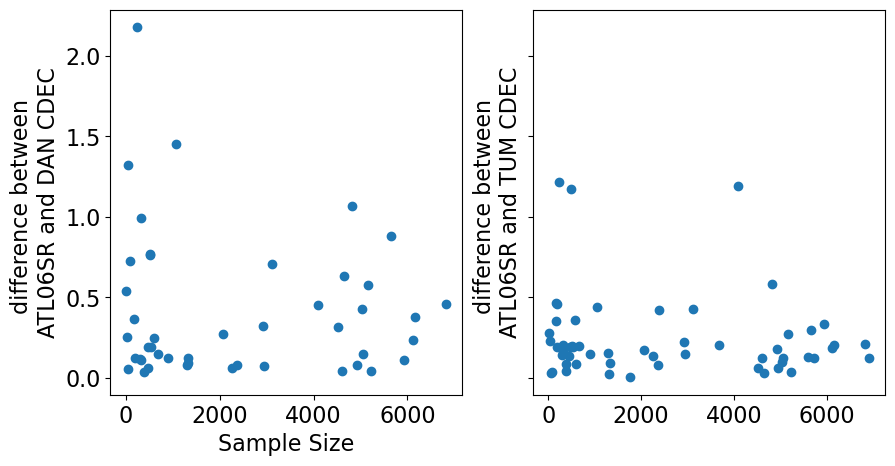

In [330]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
ax[0].scatter(comp_table_all['n'], comp_table_all['atl06-dan_diff'].abs())
ax[1].scatter(comp_table_all['n'], comp_table_all['atl06-tum_diff'].abs())
ax[0].set_xlabel('Sample Size')
ax[0].set_ylabel('difference between \nATL06SR and DAN CDEC')
ax[1].set_ylabel('difference between \nATL06SR and TUM CDEC')

# Old: See pair_comparison.ipynb for updated code
Calculate Differences Between ATL06SR and ASO Pairs

In [77]:
aso_date_list = []
for fn in aso_fn_winters:
    date_string = os.path.splitext(os.path.split(fn)[-1])[0].split('_')[-2]
    date = datetime.datetime.strptime(date_string, "%Y%m%d").date()
    aso_date_list.append(date)

In [78]:
aso_date_list

[datetime.date(2019, 3, 24),
 datetime.date(2019, 4, 17),
 datetime.date(2019, 5, 3),
 datetime.date(2020, 4, 13),
 datetime.date(2020, 5, 22),
 datetime.date(2021, 2, 25),
 datetime.date(2022, 2, 4),
 datetime.date(2022, 4, 5)]

In [79]:
print('aso length:', len(aso_date_list))
print('atl06sr length:', len(atl06_dates))

aso length: 8
atl06sr length: 8


In [113]:
comp_table = pd.DataFrame()
comp_table.index = pd.DatetimeIndex(data=sorted(atl06_dates + aso_date_list))
comp_table['acqdate'] = comp_table.index.date

In [114]:
#atl06sr_gdf.loc[atl06sr_gdf['acqdate']==date,'diff_plus']
comp_table['ATL06SR'] = ''
comp_table.loc[comp_table['acqdate'].isin(atl06_dates),'ATL06SR'] = True
comp_table.loc[comp_table['acqdate'].isin(aso_date_list),'ATL06SR'] = False

In [115]:
comp_table['ASO'] = ''
comp_table.loc[comp_table['acqdate'].isin(atl06_dates),'ASO'] = False
comp_table.loc[comp_table['acqdate'].isin(aso_date_list),'ASO'] = True

In [116]:
comp_table['pair'] = ''
for i in range(len(comp_table)):
    comp_table['pair'][i:i+1] = int(i/2)

In [117]:
comp_table['median'] = ''
for date in atl06_dates:
    comp_table.loc[comp_table['acqdate']==date, 'median'] = np.nanmedian(atl06sr_gdf.loc[atl06sr_gdf['acqdate']==date,'diff_plus'])
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'median'] = np.nanmedian(atl06sr_gdf.loc[atl06sr_gdf['ASO_snowon_date']==date,'ASO_snowon'])

In [118]:
comp_table['pair'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=object)

In [119]:
comp_table['median_diff'] = ''
for i in comp_table['pair'].unique():
    comp_table.loc[comp_table['pair']==i, 'median_diff'] = np.diff(comp_table[comp_table['pair']==i]['median'])

In [120]:
comp_table

,acqdate,ATL06SR,ASO,pair,median,median_diff
2019-03-12,2019-03-12,True,False,0,2.825406,0.155656
2019-03-24,2019-03-24,False,True,0,2.981062,0.155656
2019-04-10,2019-04-10,True,False,1,2.452357,0.106477
2019-04-17,2019-04-17,False,True,1,2.558834,0.106477
2019-05-03,2019-05-03,False,True,2,2.037935,-0.441766
2019-05-14,2019-05-14,True,False,2,1.596169,-0.441766
2020-04-07,2020-04-07,True,False,3,1.296197,-0.276697
2020-04-13,2020-04-13,False,True,3,1.0195,-0.276697
2020-05-22,2020-05-22,False,True,4,0.0,0.041656
2020-06-08,2020-06-08,True,False,4,0.041656,0.041656


In [121]:
comp_table['iqr'] = ''
for date in atl06_dates:
    comp_table.loc[comp_table['acqdate']==date, 'iqr'] = iqr(atl06sr_gdf.loc[atl06sr_gdf['acqdate']==date,'diff_plus'])
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'iqr'] = iqr(atl06sr_gdf.loc[atl06sr_gdf['ASO_snowon_date']==date,'ASO_snowon'])

In [122]:
comp_table['iqr_diff'] = ''
for i in comp_table['pair'].unique():
    comp_table.loc[comp_table['pair']==i, 'iqr_diff'] = np.diff(comp_table[comp_table['pair']==i]['iqr'])

In [123]:
comp_table['date_offset'] = ''
for i in range(len(comp_table)):
    if i%2 != 0:
        comp_table.loc[comp_table['pair']==int(i/2), 'date_offset'] = np.subtract(comp_table.index[i],comp_table.index[i-1]).days

In [124]:
comp_table['tum_depth'] = ''
# median depth on that day at the tuolumne meadows cdec pillow
for date in comp_table.index:
    comp_table.loc[comp_table.index==date,'tum_depth'] = snwd[snwd.index == date]['tum_m']

In [125]:
comp_table['dan_depth'] = ''
# median depth on that day at the tuolumne meadows cdec pillow
for date in comp_table.index:
    comp_table.loc[comp_table.index==date,'dan_depth'] = snwd[snwd.index == date]['dan_clean']

In [126]:
comp_table['delta_tum'] = ''
for i in comp_table['pair'].unique():
    comp_table.loc[comp_table['pair']==i, 'delta_tum'] = np.diff(comp_table[comp_table['pair']==i]['tum_depth'])

In [127]:
comp_table['delta_dan'] = ''
for i in comp_table['pair'].unique():
    comp_table.loc[comp_table['pair']==i, 'delta_dan'] = np.diff(comp_table[comp_table['pair']==i]['dan_depth'])

Text(0, 0.5, 'difference in the ASO \nand ATL06SR medians')

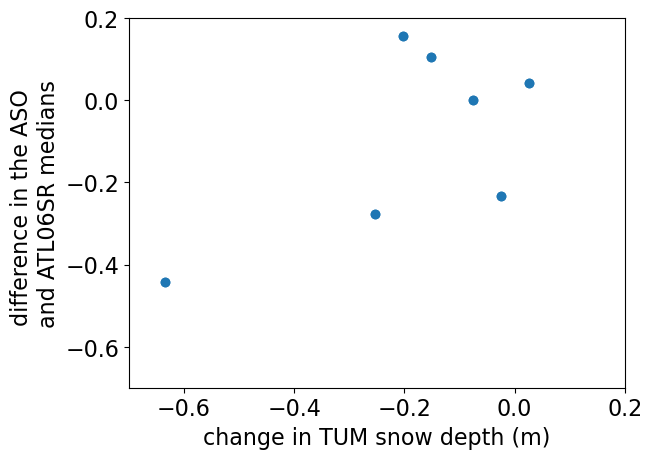

In [128]:
fig, ax = plt.subplots()
plt.scatter(comp_table['delta_tum'], comp_table['median_diff'])
plt.xlabel('change in TUM snow depth (m)')
#plt.axis('square')
plt.ylim(-0.7, 0.2)
plt.xlim(-0.7, 0.2)
plt.ylabel('difference in the ASO \nand ATL06SR medians')
#plt.axis('square')

(-0.5, 0.3)

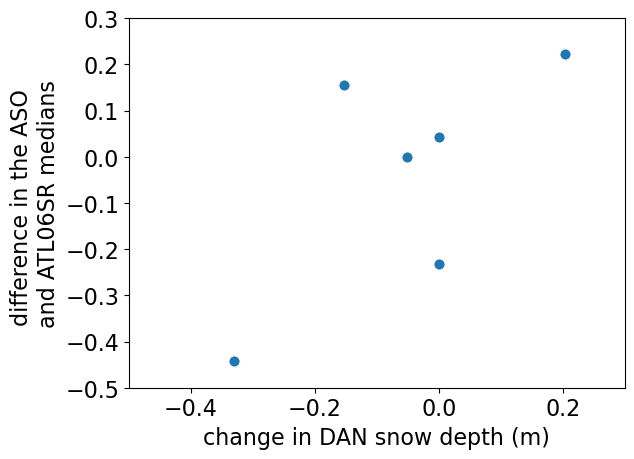

In [96]:
fig, ax = plt.subplots()
plt.scatter(comp_table['delta_dan'], comp_table['median_diff'])
plt.xlabel('change in DAN snow depth (m)')
plt.ylabel('difference in the ASO \nand ATL06SR medians')
plt.ylim(-0.5, 0.3)
plt.xlim(-0.5, 0.3)

In [97]:
comp_table.head()

,acqdate,ATL06SR,ASO,pair,median,median_diff,iqr,iqr_diff,date_offset,tum_depth,dan_depth,delta_tum,delta_dan
2019-03-12,2019-03-12,True,False,0,2.825406,0.155656,2.909036,-0.312845,12,2.4892,2.7178,-0.2032,-0.1524
2019-03-24,2019-03-24,False,True,0,2.981062,0.155656,2.596191,-0.312845,12,2.286,2.5654,-0.2032,-0.1524
2019-04-10,2019-04-10,True,False,1,2.452357,0.106477,1.248204,-0.2244,7,2.032,NaN,-0.1524,NaN
2019-04-17,2019-04-17,False,True,1,2.558834,0.106477,1.023804,-0.2244,7,1.8796,2.2352,-0.1524,NaN
2019-05-03,2019-05-03,False,True,2,2.037935,-0.441766,1.147949,0.630284,11,1.0414,1.4732,-0.635,-0.3302


Text(0, 0.5, 'delta snow depth during \nthe date offset at tum')

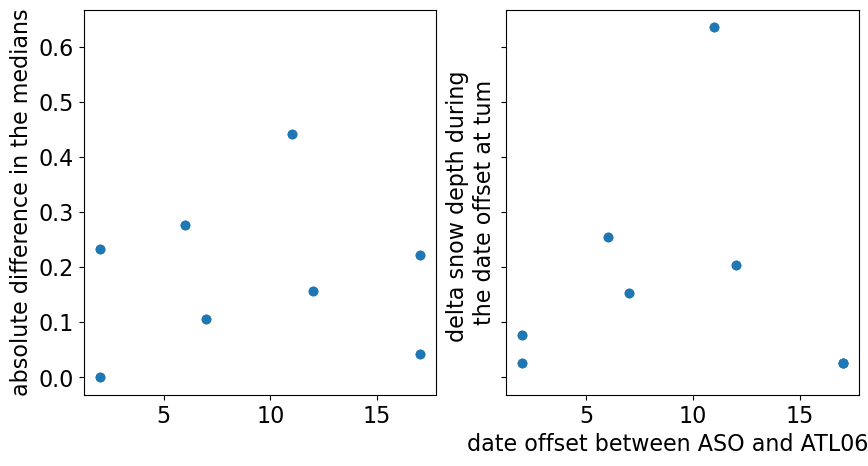

In [98]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
ax[0].scatter(comp_table['date_offset'], comp_table['median_diff'].abs())
#ax[0].set_xlabel('date offset between ASO and ATL06SR')
ax[0].set_ylabel('absolute difference in the medians')

ax[1].scatter(comp_table['date_offset'], comp_table['delta_tum'].abs())
ax[1].set_xlabel('date offset between ASO and ATL06SR')
ax[1].set_ylabel('delta snow depth during \nthe date offset at tum')

Text(0, 0.5, 'delta snow depth during \nthe date offset at tum')

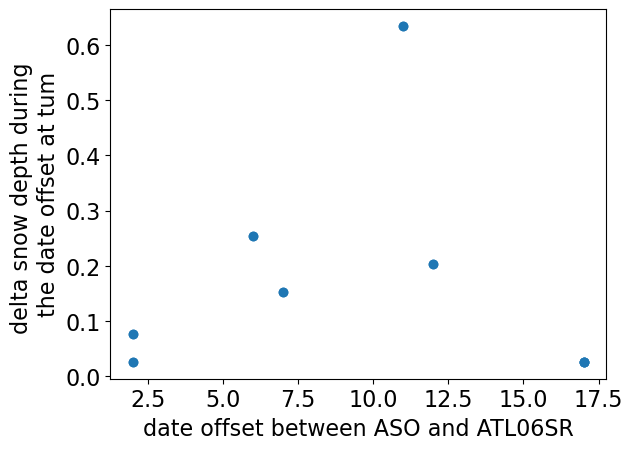

In [99]:
fig, ax = plt.subplots()
plt.scatter(comp_table['date_offset'], comp_table['delta_tum'].abs())
plt.xlabel('date offset between ASO and ATL06SR')
plt.ylabel('delta snow depth during \nthe date offset at tum')

KeyError: 'median_dif_percent'

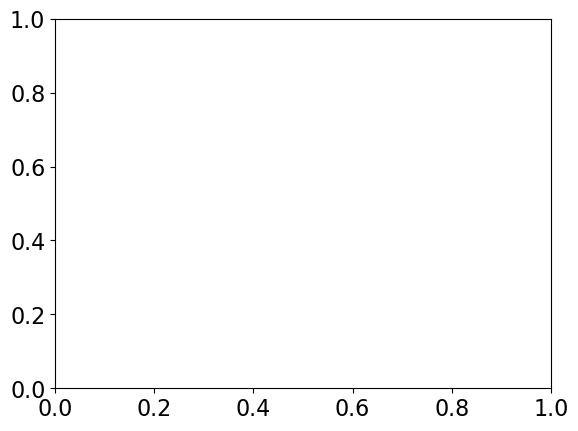

In [101]:
fig, ax = plt.subplots()
plt.scatter(comp_table['date_offset'], comp_table['median_dif_percent'])
plt.ylim(-100, 100)
plt.hlines(y=0, xmin=0, xmax=17.5, color='k', linestyle='--')
plt.xlabel('date offset between ASO and ATL06SR')
plt.ylabel('percent difference in the medians \nthe compared to median depth in the basin')

Text(0, 0.5, 'percent difference in the iqrs \ncompared to the iqr in the basin')

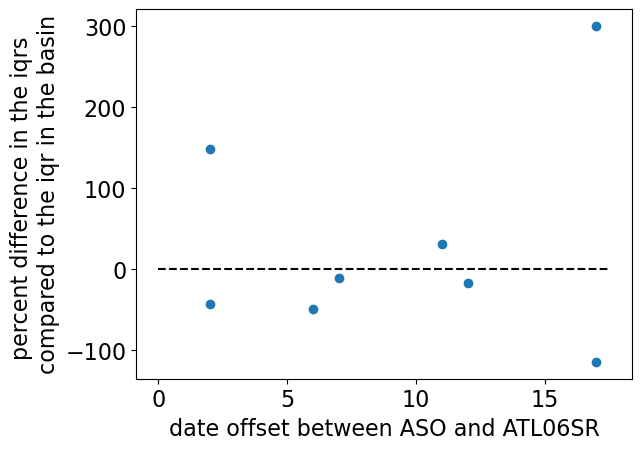

In [436]:
fig, ax = plt.subplots()
plt.scatter(comp_table['date_offset'], comp_table['iqr_dif_percent'])
#plt.ylim(-100, 100)
plt.hlines(y=0, xmin=0, xmax=17.5, color='k', linestyle='--')
plt.xlabel('date offset between ASO and ATL06SR')
plt.ylabel('percent difference in the iqrs \ncompared to the iqr in the basin')

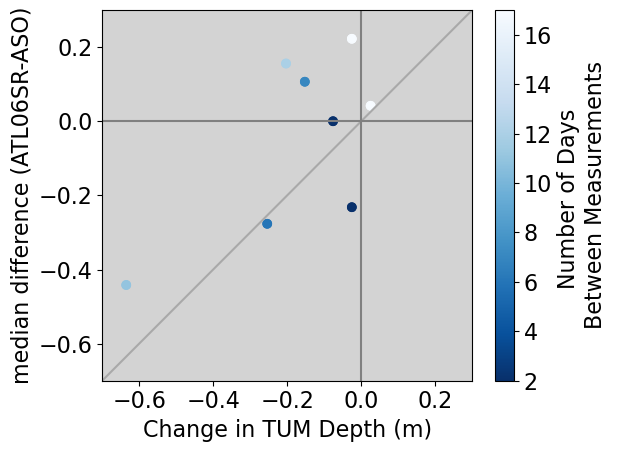

In [148]:
x = np.linspace(-7,0.3,100)
y = x

fig, ax = plt.subplots()
c=plt.scatter(comp_table['delta_tum'], comp_table['median_diff'], c=comp_table['date_offset'], cmap='Blues_r')
plt.plot(x, y, 'darkgrey', label='1:1 line')
plt.axvline(x=0, ymin=(-0.7), ymax=1, color='grey')
plt.axhline(y=0, xmin=(-0.7), xmax=1, color='grey')
plt.colorbar(c, label='Number of Days \nBetween Measurements')
#plt.ylim(-100, 100)
#plt.hlines(y=0, xmin=0, xmax=17.5, color='k', linestyle='--')
plt.ylim(-0.7, 0.3)
plt.xlim(-0.7, 0.3)
plt.xlabel('Change in TUM Depth (m)')
plt.ylabel('median difference (ATL06SR-ASO)')
ax.set_facecolor('lightgrey')
plt.tight_layout()
plt.savefig('../../figures/polished/median_dif_vs_delta_tum.jpeg', dpi=500)

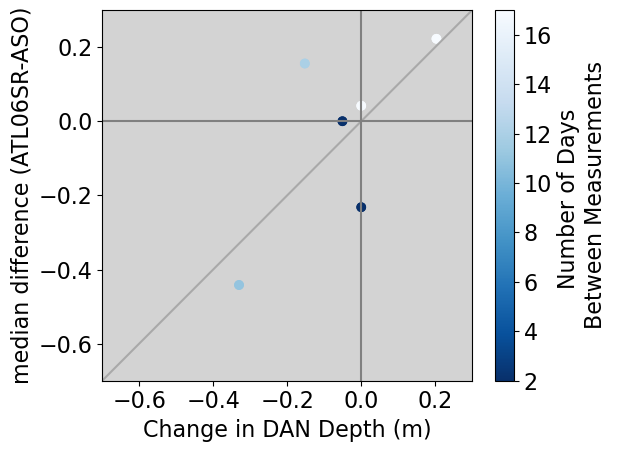

In [149]:
x = np.linspace(-0.7,0.3,100)
y = x

fig, ax = plt.subplots()
c=plt.scatter(comp_table['delta_dan'], comp_table['median_diff'], c=comp_table['date_offset'], cmap='Blues_r')
plt.plot(x, y, 'darkgrey', label='1:1 line')
plt.axvline(x=0, ymin=(-0.7), ymax=1, color='grey')
plt.axhline(y=0, xmin=(-0.7), xmax=1, color='grey')
plt.colorbar(c, label='Number of Days \nBetween Measurements')
#plt.ylim(-100, 100)
#plt.hlines(y=0, xmin=0, xmax=17.5, color='k', linestyle='--')
plt.ylim(-0.7, 0.3)
plt.xlim(-0.7, 0.3)
plt.xlabel('Change in DAN Depth (m)')
plt.ylabel('median difference (ATL06SR-ASO)')
ax.set_facecolor('lightgrey')
plt.tight_layout()
plt.savefig('../../figures/polished/median_dif_vs_delta_dan.jpeg', dpi=500)

In [102]:
# written by Hannah Besso, Oct 14, 2022

def build_basin_df(raster_list = None, region = None):
    stats_df = pd.DataFrame()
    for file in raster_list:
        rasterstats = zonal_stats(region, file, nodata=(-9999.0), stats="mean min max median percentile_25 percentile_75 count")
        rasterstats[0]['iqr'] = rasterstats[0]['percentile_75'] - rasterstats[0]['percentile_25']
        date = os.path.splitext(os.path.split(file)[-1])[0].split('_')[-2]
        date2 = pd.to_datetime(date)
        stats_df = pd.concat([stats_df, pd.DataFrame(rasterstats[0], index=[date2])])
    stats_df['acqdate'] = stats_df.index.date
    return stats_df

In [103]:
basin_df = build_basin_df(raster_list=aso_fn_winters, region=outline_gdf)

In [104]:
basin_df

,min,max,mean,count,median,percentile_25,percentile_75,iqr,acqdate
2019-03-24,-1.039112,22.367649,2.744573,2915368,2.838950,1.887053,3.601881,1.714828,2019-03-24
2019-04-17,-0.879300,22.962400,2.443612,2915748,2.544456,1.465045,3.350062,1.885017,2019-04-17
2019-05-03,-1.206003,42.400269,1.708364,2915383,1.719352,0.533913,2.522527,1.988614,2019-05-03
2020-04-13,-0.292035,21.189863,0.983854,2646253,0.983526,0.289719,1.471155,1.181436,2020-04-13
2020-05-22,-0.218361,20.824833,0.265674,2792407,0.010931,0.000000,0.337922,0.337922,2020-05-22
2021-02-25,-0.366888,7.820531,0.966758,2906850,1.049031,0.621652,1.327524,0.705872,2021-02-25
2022-02-04,-0.232013,11.518790,1.000802,1235354,1.036890,0.647384,1.318633,0.671249,2022-02-04
2022-04-05,-0.200172,11.080725,0.609790,1157340,0.508277,0.115128,0.909294,0.794165,2022-04-05


In [129]:
comp_table['basin_median'] = np.nan
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'basin_median'] = basin_df.loc[basin_df['acqdate']==date,'median']

In [130]:
comp_table['median_basin_percent'] = np.nan
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'median_basin_percent'] = comp_table.loc[comp_table['acqdate']==date, 'median_diff'] / comp_table.loc[comp_table['acqdate']==date, 'basin_median'] * 100

In [131]:
comp_table['median_track_percent'] = np.nan
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'median_track_percent'] = comp_table.loc[comp_table['acqdate']==date, 'median_diff'] / comp_table.loc[comp_table['acqdate']==date, 'median'] * 100

In [132]:
comp_table['iqr_track_percent'] = np.nan
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'iqr_track_percent'] = comp_table.loc[comp_table['acqdate']==date, 'iqr_diff'] / comp_table.loc[comp_table['acqdate']==date, 'iqr'] * 100

In [133]:
comp_table['basin_iqr'] = np.nan
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'basin_iqr'] = basin_df.loc[basin_df['acqdate']==date,'iqr']

In [134]:
comp_table['iqr_basin_percent'] = np.nan
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'iqr_basin_percent'] = comp_table.loc[comp_table['acqdate']==date, 'iqr_diff'] / comp_table.loc[comp_table['acqdate']==date, 'basin_iqr'] * 100

In [135]:
comp_table

,acqdate,ATL06SR,ASO,pair,median,median_diff,iqr,iqr_diff,date_offset,tum_depth,dan_depth,delta_tum,delta_dan,basin_median,median_basin_percent,median_track_percent,iqr_track_percent,basin_iqr,iqr_basin_percent
2019-03-12,2019-03-12,True,False,0,2.825406,0.155656,2.909036,-0.312845,12,2.4892,2.7178,-0.2032,-0.1524,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-24,2019-03-24,False,True,0,2.981062,0.155656,2.596191,-0.312845,12,2.286,2.5654,-0.2032,-0.1524,2.838950,5.482886,5.221507,-12.05014,1.714828,-18.243507
2019-04-10,2019-04-10,True,False,1,2.452357,0.106477,1.248204,-0.2244,7,2.032,NaN,-0.1524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-17,2019-04-17,False,True,1,2.558834,0.106477,1.023804,-0.2244,7,1.8796,2.2352,-0.1524,NaN,2.544456,4.184677,4.161163,-21.918265,1.885017,-11.904404
2019-05-03,2019-05-03,False,True,2,2.037935,-0.441766,1.147949,0.630284,11,1.0414,1.4732,-0.635,-0.3302,1.719352,-25.693737,-21.677132,54.905226,1.988614,31.694648
2019-05-14,2019-05-14,True,False,2,1.596169,-0.441766,1.778233,0.630284,11,0.4064,1.143,-0.635,-0.3302,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-07,2020-04-07,True,False,3,1.296197,-0.276697,1.422136,-0.578227,6,0.7112,NaN,-0.254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-13,2020-04-13,False,True,3,1.0195,-0.276697,0.843909,-0.578227,6,0.4572,1.524,-0.254,NaN,0.983526,-28.133181,-27.140498,-68.517762,1.181436,-48.942736
2020-05-22,2020-05-22,False,True,4,0.0,0.041656,0.298129,1.01513,17,0.0508,0.0,0.0254,0.0,0.010931,381.066764,inf,340.499902,0.337922,300.403707
2020-06-08,2020-06-08,True,False,4,0.041656,0.041656,1.313259,1.01513,17,0.0762,0.0,0.0254,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
comp_table.to_csv('../../figures/comp_table.csv')

In [486]:
np.nanmedian(comp_table['median_diff'])

0.020830463217976103

In [490]:
np.nanmin(comp_table['median_diff'].abs())

4.899748319076025e-06

In [491]:
np.nanmax(comp_table['median_diff'].abs())

0.44176575335950474

In [494]:
comp_table['median_track_percent'].describe()

count     8.000000
unique    8.000000
top       5.221507
freq      1.000000
Name: median_track_percent, dtype: float64

In [496]:
np.nanmin(comp_table['median_track_percent'].abs())

0.0008307312229049511

In [497]:
np.nanmax(comp_table['median_track_percent'].abs())

inf

In [498]:
np.nanmedian(comp_table['median_track_percent'].abs())

20.79296636968199

In [505]:
np.nanmin(comp_table['iqr_diff'].abs())

0.22440000580900232

In [506]:
np.nanmax(comp_table['iqr_diff'].abs())

1.0151301455530302

In [507]:
np.nanmedian(comp_table['iqr_diff'].abs())

0.6042556821217886

In [539]:
np.nanmin(comp_table['iqr_track_percent'].abs())

12.050140086831174

In [540]:
np.nanmax(comp_table['iqr_track_percent'].abs())

340.4999023858529

In [542]:
np.nanmedian(comp_table['iqr_track_percent'].abs())

71.7444662298708

In [ ]:
# Write to file
    with open(
        os.path.splitext(
            os.path.basename(__file__))[0] + ".tbl", "w") as f:

        format = "l" + \
            "@{\hskip 12pt}" +\
            4*"S[table-format = 2.2]"

        f.write(df.head()
                .to_latex(index=False,
                          escape=False,
                          column_format=format)
                )

